<a href="https://colab.research.google.com/github/seokiho/kisti-police/blob/main/jsonReader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [32]:
import csv
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


In [33]:


# JSON Data structure
#
#   "score": {
#     "-NOhScUFQniRJwhbp85s": {
#       "crm_set": 1,
#       "date_set": 1,
#       "dtime": "15:11:55",
#       "key": "-NOhScUFQniRJwhbp85s",
#       "score_cos": 52.81,
#       "score_lcs": 19.91,
#       "subj_set": 0,
#       "text_con": "2023. 2. 11. 09:30경 장소모르는 곳에서 피해자 김피해에게 아들 이철수라고 하며 카카오톡을 통하여 50만원을 입금해달라고 연락하였다.  이에 속은 피해자는 같은 날 10:20경 김범인 명의 국민은행 계좌(638010064222)로 50만원을 입금하였다.",
#       "whr_set": 1,
#       "word_set": 1
#     },


def json_to_csv(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # exraction list by fields' names
    fields = ["score_cos", "score_lcs", "text_con"]

    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(fields)

        for key, item in data["score"].items():  # extract only key of "score" data
            row = [item.get(field, None) for field in fields]
            writer.writerow(row)


# set the files' paths
input_file_path = "/content/gdrive/MyDrive/vltldtkdlxm312-default-rtdb-export.json"
output_file_path = "/content/gdrive/MyDrive/output_all.csv"

# JSON TO CSV
json_to_csv(input_file_path, output_file_path)





####################################################################

                     JSON에서 추출한 데이터 정보

####################################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2350 entries, 0 to 2349
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   score_cos  2350 non-null   float64
 1   score_lcs  2350 non-null   float64
 2   text_con   2350 non-null   object 
dtypes: float64(2), object(1)
memory usage: 55.2+ KB


####################################################################

           유사도에 따라 분류 후 데이터프래임(df) 정보

####################################################################




      score_cos  score_lcs  \
0         52.81      19.91   
1         52.38      24.67   
2         45.02      11.25   
3         48.91      20.77   
4         54.31       8.62   
...         ...        ...   
2345      35.47      11.11   
2346      66.50       9.56   
2347 

<Axes: xlabel='classification', ylabel='count'>

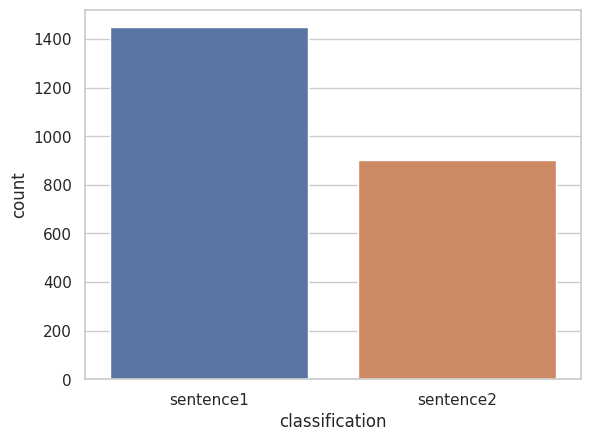

In [34]:

input_csv_file = '/content/gdrive/MyDrive/output_all.csv'

data = pd.read_csv(input_csv_file, encoding="utf-8")


# EDA, no blank trunk data

print("\n\n####################################################################\n")
print("                     JSON에서 추출한 데이터 정보\n")
print("####################################################################\n")

data.info()

# text_con에는 두 가지 시나리오로 구성되므로 라벨링이 필요
# 텍스트 분류 기준은 답안 예시와 유사도 큰 값으로 분류

sentence1 = "피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김피해에게 아들 이철수라고 하며 '급히 돈이 필요한데 휴대폰이 고장나서 OTP가 안되니 대신 송금해주면 집에서 돌려주겠다.'는 카카오톡 메시지를 보냈다. 피혐의자는 아들 이철수를 사칭하여 거짓말하였다. 피혐의자는 이에 속은 피해자로부터 같은 날 10:20경 김범인 명의 국민은행 계좌(638-01-0064-222)로 50만 원 교부받았다."
sentence2 = "피혐의자는 2023. 2. 11. 13:00경 장소를 알 수 없는 곳에서 피해자 나피해(38세, 여)에게 KB저축은행 대출상담원 김지영 실장으로 속이며 'KB캐피탈 대출'을 상환하면 저금리로 대환할 수 있다고 하였다. 피혐의자는 KB저축은행 앱을 설치하고 대출을 접수하면 심사 후 대출금을 지급해 주겠다고 하면서 원격접속용 앱을 설치하게 하고, 인터넷으로 대출신청서를 작성하게 하였다. 피혐의자는 같은 날 13:30경 '심사 중 대출 상환 위반 사실이 발견되어 기존 대출금을 갚아야 새로운 대출이 가능하다, 금융위원회 직원이 기존 대출금을 회수하러 방문할 테니, 그 직원에게 기존 대출금을 상환하면 된다.'는 취지로 거짓말하였다. 피혐의자는 사실 KB저축은행 직원이 아니었고 피해자에게 저금리 대환대출을 해줄 의사나 능력이 없었다. 피혐의자는 이에 속은 피해자로부터 같은 날 15:20경 충북 충주시 예성로 156에 있는 KB국민은행 충주지점 앞 노상에서 현금 1,580만 원을 교부받았다."

def calculate_text_similarity(input_text, sentence1, sentence2):
    vectorizer = CountVectorizer().fit([input_text, sentence1, sentence2])

    input_vector = vectorizer.transform([input_text])
    vector1 = vectorizer.transform([sentence1])
    vector2 = vectorizer.transform([sentence2])

    similarity1 = cosine_similarity(input_vector, vector1)[0][0]
    similarity2 = cosine_similarity(input_vector, vector2)[0][0]

    return similarity1, similarity2


df = pd.DataFrame(data)

similarities = df.apply(lambda row: calculate_text_similarity(row['text_con'], sentence1,sentence2), axis=1)
df['similarity1'] = similarities.apply(lambda x: x[0])
df['similarity2'] = similarities.apply(lambda x: x[1])

# 'classification'을 추가, 코사인 유사도에 따라 시나리오별(sentence1, sentence2)로 분류
df['classification'] = df.apply(lambda row: 'sentence1' if row['similarity1'] >= row['similarity2'] else 'sentence2', axis=1)


print("\n\n####################################################################\n")
print("           유사도에 따라 분류 후 데이터프래임(df) 정보\n")
print("####################################################################\n\n\n\n")

print(df)

data1 = df[df['classification'] == 'sentence1']
data2 = df[df['classification'] == 'sentence2']

# Sentence1(시나리오 1) : 1,448건
# Sentence2(시나리오 2) :   902건
# 합계 : 총  총 2,350건


print("\n\n\n\n####################################################################\n")
print("                시나리오별(data1, data2) 데이터 정보\n")
print("####################################################################\n")


data1.info()
data2.info()

sns.countplot(data=df, x='classification', order=['sentence1','sentence2'])




In [35]:
#####################################################################################
# 분류가 잘못되는 결과가 일부 나타남.
# 첫 번째 미션, 유사도만으로 분류하지 말고 기계학습을 통한 분류를 구현
#####################################################################################

# 데이터가 없다..?





In [36]:



#######################################################################################
# 시나리오 1, 2별로 데이터프래임을 생성하고 각각의 유사도를 산출한다.
#######################################################################################


#"text_con" 컬럼의 문자열 값만 추출
result1 = data1['text_con'].tolist()
result2 = data2['text_con'].tolist()

result1.append(sentence1)
result2.append(sentence2)

def calculate_similarity(data):
    # TF-IDF 벡터화
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(data)

    # 코사인 유사도 측정
    cosine_similarities = cosine_similarity(tfidf_matrix)

    # 맨해튼 유사도 측정
    manhattan_similarities = 1 / (1 + manhattan_distances(tfidf_matrix))

    # 유클리드 유사도 측정
    euclidean_similarities = 1 / (1 + euclidean_distances(tfidf_matrix))

    # 결과를 데이터프레임으로 저장
    results = pd.DataFrame({
    'text_con': data,
    'cosine_similarity': cosine_similarities[-1],
    'manhattan_similarity': manhattan_similarities[-1],
    'euclidean_similarity': euclidean_similarities[-1]

    })

    return results

results1 = calculate_similarity(result1)
results2 = calculate_similarity(result2)

#유사도 비교를 위해 append 했던 값은 삭제한다.
results1 = results1.drop(results1.index[-1])
results2 = results2.drop(results2.index[-1])

#results1.pop()
#results2.pop()


print("\n\n\n\n####################################################################\n")
print("                시나리오별(result1, result2) 데이터 정보\n")
print("####################################################################\n")

print(results1.info())
print(results2.info())

print("\n\n\n\n####################################################################\n")
print("                데이터 출력(result1, result2) 데이터 정보\n")
print("####################################################################\n")

print(results1)
print(results2)


# 기존에 산출했던 코사인 유사도와 이번에 산출한 코사인 유사도간 상관관계를 알아본다.

###################################################################################

# 텍스트와 3가지 유사도를 각각 산출한 result1, result2의 데이터 프래임을 병합

results1.reset_index(drop=True, inplace=True)
results2.reset_index(drop=True, inplace=True)
combined_results = pd.concat([results1, results2], ignore_index=True)


print("\n\n\n\n####################################################################\n")
print("            합쳐진 결과 데이터 정보 (combined_results)\n")
print("####################################################################\n")

print(combined_results.info())

print("\n\n\n\n####################################################################\n")
print("            합쳐진 데이터 출력 (combined_results)\n")
print("####################################################################\n")

print(combined_results)







####################################################################

                시나리오별(result1, result2) 데이터 정보

####################################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text_con              1448 non-null   object 
 1   cosine_similarity     1448 non-null   float64
 2   manhattan_similarity  1448 non-null   float64
 3   euclidean_similarity  1448 non-null   float64
dtypes: float64(3), object(1)
memory usage: 45.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text_con              902 non-null    object 
 1   cosine_similarity     902 non-null    float64
 2   manhattan_similarity  902

In [37]:

# df.isna().sum()
# combined_results.isna().sum()

atall_results = pd.merge(df, combined_results, on=['text_con'], how = "inner")
#atall_results = pd.concat([df, combined_results],axis=1)

atall_results.info()

print(atall_results)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2606 entries, 0 to 2605
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   score_cos             2606 non-null   float64
 1   score_lcs             2606 non-null   float64
 2   text_con              2606 non-null   object 
 3   similarity1           2606 non-null   float64
 4   similarity2           2606 non-null   float64
 5   classification        2606 non-null   object 
 6   cosine_similarity     2606 non-null   float64
 7   manhattan_similarity  2606 non-null   float64
 8   euclidean_similarity  2606 non-null   float64
dtypes: float64(7), object(2)
memory usage: 203.6+ KB
      score_cos  score_lcs  \
0         52.81      19.91   
1         52.38      24.67   
2         45.02      11.25   
3         45.02      11.25   
4         45.02      11.25   
...         ...        ...   
2601      35.47      11.11   
2602      66.50       9.56   
2603     

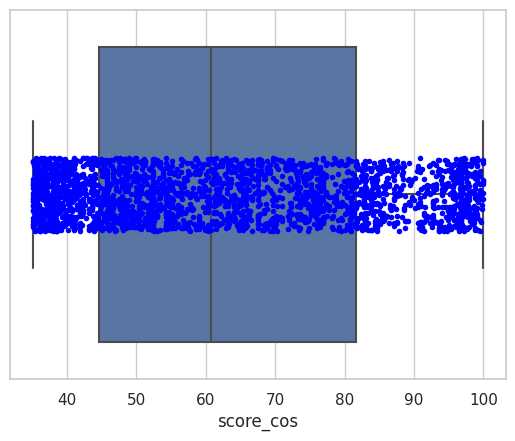

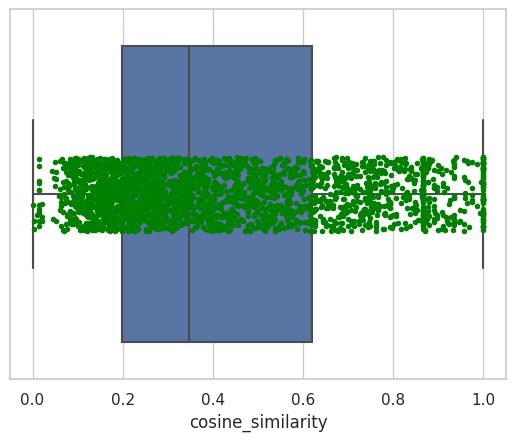

                     z_score_cos  z_cosine_similarity
z_score_cos             1.000000             0.854988
z_cosine_similarity     0.854988             1.000000


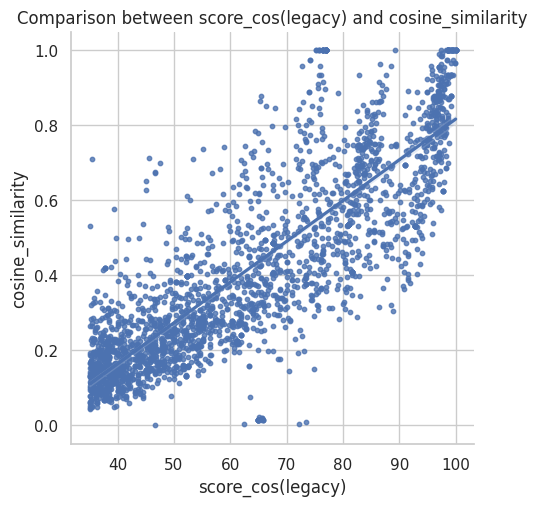

In [38]:
##################################################################################


sns.set(style='whitegrid')

ax = sns.boxplot(data=atall_results,x='score_cos' )  # 'x_column'과 'y_column'은 데이터셋의 컬럼 이름
sns.stripplot(data=atall_results, x='score_cos', color='blue', size=4, jitter=True)

plt.show()

ax = sns.boxplot(data=atall_results, x='cosine_similarity' )  # 'x_column'과 'y_column'은 데이터셋의 컬럼 이름
sns.stripplot(data=atall_results,x='cosine_similarity', color='green', size=4, jitter=True)


plt.show()


####################################################################################
# 기존에 측정했던 코사인 유사도(웹)와 다시 측정한 유사도값과 비교
####################################################################################


score_cos = atall_results['score_cos']
cosine_similarity = atall_results['cosine_similarity']

# # 데이터를 표준화 (z-score 변환)
z_score_cos = zscore(score_cos)
z_cosine_similarity = zscore(cosine_similarity)

# 표준화된 값을 사용하여 새로운 DataFrame 생성
z_scores_df = pd.DataFrame({'z_score_cos': z_score_cos, 'z_cosine_similarity': z_cosine_similarity})

# 표준화된 변수로 상관 계수 계산
corr = z_scores_df.corr(method='pearson')
print(corr)

sns.lmplot(x='score_cos', y='cosine_similarity', data=atall_results, scatter_kws={'s': 10})
plt.xlabel('score_cos(legacy)')
plt.ylabel('cosine_similarity')
plt.title('Comparison between score_cos(legacy) and cosine_similarity')
plt.show()

# 정규화는 데이터의 범위를 [0, 1] 또는 [-1, 1]과 같은 일정한 범위로 변환
# 정규화는 변수의 상대적인 크기를 유지하면서 값 조정. 최소값을 0, 최대값을 1로 맞추는 경우
# MinMaxScaler를 사용. 정규화를 사용하면 변수 간 범위의 차이가 줄어듦.

# 표준화는 데이터의 평균을 0으로, 표준 편차를 1로 만듦. 변수의 분포를 정규 분포에 가깝게 만듦.
# 간단한 예시로, '정규화'는 변수 간 범위를 같게 함. '표준화'는 변수의 평균과 분산을 통제하여 분포를 변환..
#'정규화'는 데이터의 스케일을 조정하고, '표준화'는 데이터의 분포를 변환하여 모델의 성능 향상을 목적.



# atall_results 데이터프레임으로부터 'score_cos'와 'cosine_similarity' 컬럼만 추출
# subset_columns = ['score_cos', 'cosine_similarity']
# subset_df = atall_results[subset_columns]

# 표준화 (Standardization)
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(subset_df)
# df_standardized = pd.DataFrame(scaled_data, columns=subset_df.columns)

# 정규화 (Normalization)
# scaler = MinMaxScaler()
# normalized_data = scaler.fit_transform(subset_df)
# df_normalized = pd.DataFrame(normalized_data, columns=subset_df.columns)

# 표준화된 값으로 비교
# print("Standardized Data:")
# print(df_standardized)

# 정규화된 값으로 비교
# print("\nNormalized Data:")
# print(df_normalized)


# cols = ['score_cos','cosine_similarity']
# corr = df_standardized[cols].corr(method='pearson')
# print(corr)

# sns.set_theme(style="white")

# sns.relplot(hue=None,
#             sizes=(40, 400), alpha=.5, palette="muted",
#             height=6, data=df_standardized)


# sns.relplot(hue=None,
#             sizes=(40, 400), alpha=.5, palette="muted",
#             height=6, data=df_standardized)


#######################################################################################
###  피어슨 계수가 0.8을 넘었으므로 아주 강한 양의 증가 관계.
### 기존에 평가했던 방법과 새로 측정해본 코사인 유사도는 양의 관계가 성립한다고 본다.##
#######################################################################################



                      cosine_similarity  manhattan_similarity  \
cosine_similarity              1.000000              0.752292   
manhattan_similarity           0.752292              1.000000   
euclidean_similarity           0.871321              0.970500   

                      euclidean_similarity  
cosine_similarity                 0.871321  
manhattan_similarity              0.970500  
euclidean_similarity              1.000000  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2606 entries, 0 to 2605
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cosine_similarity     2606 non-null   float64
 1   manhattan_similarity  2606 non-null   float64
 2   euclidean_similarity  2606 non-null   float64
dtypes: float64(3)
memory usage: 81.4 KB


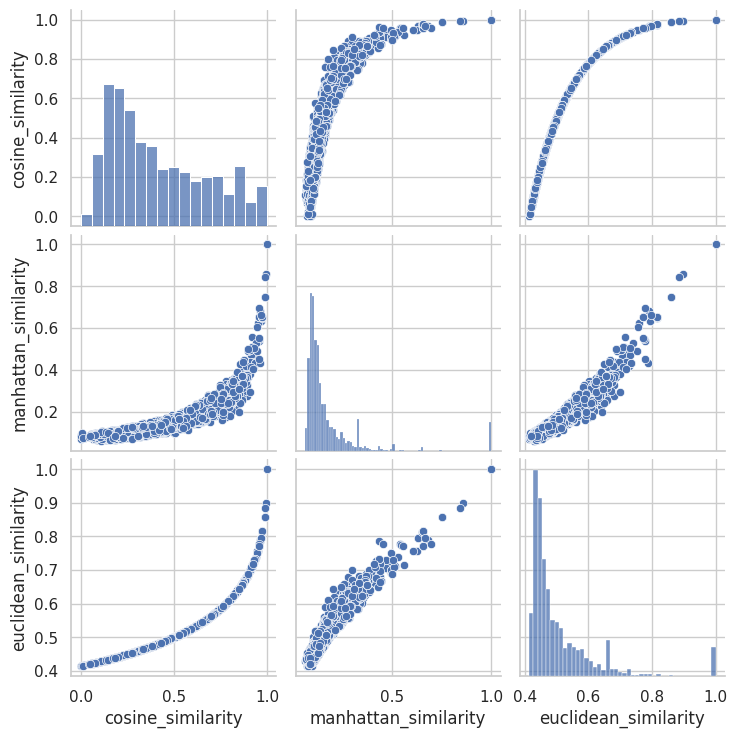

In [39]:


############################################################################
# 두 번째, 다른 유사도 평가방법들 간의 상관관계 확인하고
# 추출한 다른 유사도들 간의 값들을 비교
############################################################################



# merge된 데이터 중 'cosine_similarity' , 'manhattan_similarity', 'euclidean_similarity' 컬럼만 추출

cols = ['cosine_similarity' , 'manhattan_similarity', 'euclidean_similarity']
subset_df = atall_results[cols]
corr = subset_df.corr(method='pearson')
print(corr)

################################################################
# 피어슨 상관계수가 0.75 이상으로 확인
################################################################

subset_df.info()

sns.pairplot(subset_df)



주성분: [0.90246013 0.09645076 0.00108912]


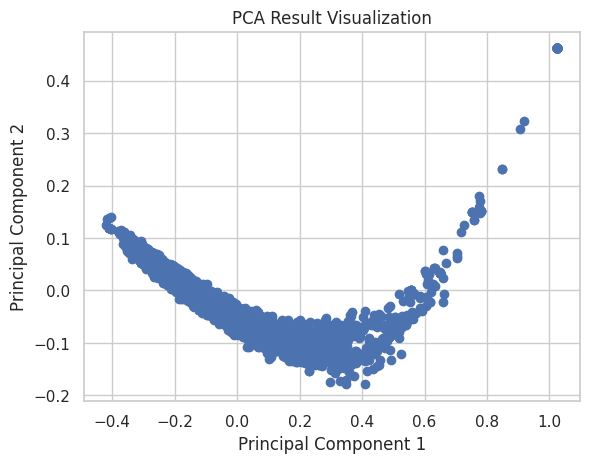

주성분 1의 설명 분산: 0.9025, 누적 설명 분산: 0.9025
주성분 2의 설명 분산: 0.0965, 누적 설명 분산: 0.9989
주성분 3의 설명 분산: 0.0011, 누적 설명 분산: 1.0000


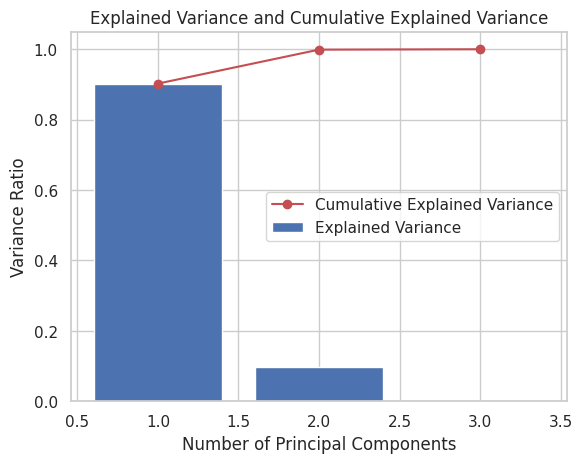

In [41]:
#############################################################################
# 세 개의 유사도 값을 어떻게 하나의 값으로 ... 가능한가? (KISTI에 물어보자) #
# 특성을 남겨서 하나의 값으로하는 주성분 분석                               #
# 평균값, 가중치 평균값 등                                                  #
#############################################################################

# PCA 모델 생성
pca = PCA()

# 데이터에 PCA 적용
pca_result = pca.fit_transform(subset_df)

# 주성분 결괏값
explained_variance_ratio = pca.explained_variance_ratio_
print("주성분:", explained_variance_ratio)


plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result Visualization')
plt.show()


# 누적 설명 분산 계산
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# 설명 분산 및 누적 설명 분산 출력
for i, ratio in enumerate(explained_variance_ratio):
    print(f"주성분 {i + 1}의 설명 분산: {ratio:.4f}, 누적 설명 분산: {cumulative_explained_variance[i]:.4f}")

# 설명 분산 및 누적 설명 분산 시각화
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, label='Explained Variance')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', color='r', label='Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Ratio')
plt.legend()
plt.title('Explained Variance and Cumulative Explained Variance')
plt.show()



In [30]:


#pd.set_option("display.max_colwidth", None)

df5 = pd.DataFrame(atall_results)
result = df5[df5['cosine_similarity'] <= 0.01]
print(result)

###########################################################################
# 새로 측정한 코사인 유사도 값이 0.01 이하인 경우가 4건 발견              #
# 고의든 아니든, 점수 부여를 0점으로 할 수 없다.                          #
# 쓴 내용에 맞게 유사도 외 점수를 부여해주는 모델을 만들어 보고자..       #

############################################################################
# 기존의 평갓값으로 입력받은 텍스트에 대해 유사도 값을 예측하는            #
# 회귀분석으로 모델을 만들어보자.                                          #
############################################################################

# PCA의 결괏값을 바탕으로 학습을 시킨 후 점수를 주는 모델은 어떠한가?
# 단순 유사도 측정하는 방법 대신 학습된 모델로 평가해주는 걸 한 번...


      score_cos  score_lcs  \
991       72.22       2.99   
1692      62.44       2.61   
1795      46.58       1.20   
2292      73.50       3.84   

                                                                                                                                                                                                                                                                                                                                                                       text_con  \
991                                                                                                                                                                                피험의자는2023.2.11.0930명장소를모르는곳에서피해자김피해\n에게아들이철수라고하며'급히돈이필요한데휴대폰이고장나서\nOTP가안되니대신송금해주면집에서돌려주겠다'는카카오톡메시 지를보냈다.피의자는아들이철수를사칭하여거짓말하였다.피험 의자는이에속은피해자로부터같은날10:20경김범인명의국민은\n행계좌(638010064222)로50만원교부받았다.   
1692  피회의자는2023.211.13:00년장소를알수없는곳에서피해자나 피해(33세,여)에게KB저축은행대출상담원김지영신장으로속이미\nKB개피탈대출을상환하면저금리로대한할수있다고하였다. 피혐의자

In [ ]:
# 모델 구현방법에는, 다양. 어떤 게 적합할지는?
# 1. 단순회귀도 나쁘지 않을 듯.
# 2. XGBoost, LSTM 정도를 생각해보자.

















